# Group 2: Phase 1 - Cats vs Dogs Detector (CaDoD)

## Team Members

* Ben Perkins
* Lauren Madar
* Mangesh Walimbe
* Samin Barghan

## Project Abstract

The task of classifying images is currently fertile ground for research in the area of computer vision and deep learning. One of the fundamental tasks involved is that of object detection within the images. A so-called ‘bounding box’ is drawn which gives the algorithm used a rectangular area to work with, as opposed to the much more unbounded irregular areas of a natural object. In order to predict these bounding boxes, our team will implement a Linear Regression model with gradient descent to achieve convergence. The task of classifying the given images as ‘Cat’ or ‘Dog’ will be handled at first by a Logistic Regression model. This will arrive at predictions via stochastic gradient descent, primarily because of the large size of the data. This will allow for a very good fit, but in a much less resource-intensive manner than with standard gradient descent. Both models will be evaluated by Average Precision, which is a standard metric for image classification. Additionally, both CXE and MSE will be used as well. We also plan to implement a confusion matrix and the Area Under Curve based on the Precision and Recall metrics, as these are often used to estimate how well a model performs. Our pipeline will include both column and image transformers, feature engineering for numeric data, and a regression pipeline.

## Project Description

The purpose of this project is create an end to end pipeline in machine learning to create an object detector for cats and dogs. There are about 13,000 images of varying shapes and aspect ratios. They are all RGB images and have bounding box coordinates stored in a .csv file. In order to create a detector, we will first have to preprocess the images to be all of the same shapes, take their RGB intensity values and flatten them from a 3D array to 2D. Then we will feed this array into a linear classifier and a linear regressor to predict labels and bounding boxes.

In [122]:
#todo preprocessing steps if needed

## Data Description

The image archive `cadod.tar.gz` is a subset [Open Images V6](https://storage.googleapis.com/openimages/web/download.html). It contains a total of 12,966 images of dogs and cats.


Image bounding boxes are stored in the csv file `cadod.csv`. The following describes whats contained inside the csv.

* ImageID: the image this box lives in.
* Source: indicates how the box was made:
    * xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
    * activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
* LabelName: the MID of the object class this box belongs to.
* Confidence: a dummy value, always 1.
* XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
* XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.

The attributes have the following definitions:

* IsOccluded: Indicates that the object is occluded by another object in the image.
* IsTruncated: Indicates that the object extends beyond the boundary of the image.
* IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
* IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
* IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).
For each of them, value 1 indicates present, 0 not present, and -1 unknown.

Identifying columns: ImageID, Source, LabelName, Confidence

Dimensional and positional columns: XMin, XMax, YMin,YMax, XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y

Bounding box and image descriptive columns: IsOccluded, IsTruncated, IsGroupOf, IsDepiction, IsInside

When we look at a few random images, we can see that the photos vary in color and have different shapes and sizes. Also, we can see a photo with both a cat and dog, with the cat being barely visible (bottom row middle) so this shows any classifier fit on this type of photos will have to be robust.

![Sample Images](https://iu.instructure.com/users/6469957/files/119176770/preview?verifier=vwgzljiRpIRlNhVQK4aPqNwqrlygkVDkhnAhSrNf)

The first step to prepare data must be to standardize the images. Photos will have to be reshaped before modeling so that all images have the same shape and size. One approach we may use would be to load all photos and look at the distribution of the photo widths and heights then determine a new image size that fits the majority of the images. Smaller size allows a model to train more quickly. Another approach would be to start with a fixed size of 200x200 pixels. We can also filter color images to determine where the majority or highest density of each color pixel lies within the image.

The metadata contained in the csv file will need to be matched to each image file, and during Exploratory Data Analysis, we will determine relationships between any of the columns using pandas. For example, how many images contain more than one cat or dog (IsGroupOf)? How many of those images have IsOccluded, IsTruncated, IsInside? Can we determine if the bounding box of one object is larger than the other in order to guess the ‘main’ object? This will drive creation of additional features.

The code and project files are stored in a GitHub repository: i526Sp21Group2 (SEE PDF). We will impute missing data and document the strategy used, if needed (depending on the results of EDA). NumPy DataFrames embedded in our project Jupyter Notebook will track our exploration and transformation of data and engineering of any features ahead of training and fitting. Other Python libraries may be used for visualizations and will be documented.

In [6]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import tarfile
from tqdm.notebook import tqdm
import warnings

# Import Data

### Unarchive data

Place the cadod.tar.gz into the same folder as this notebook. We've already extracted the files into the ./data folder (to prevent committing the large gz file to github).

In [7]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [8]:
path = 'data/cadod/'

#extract_tar('cadod.tar.gz', path) #uncomment this line if you need to extract the gzip.

### Load bounding box meta data

In [9]:
df = pd.read_csv('data/cadod.csv')

In [10]:
df.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick  /m/0bt9lr           1  0.165000  0.903750   
1  0000cb13febe0138  xclick  /m/0bt9lr           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick  /m/0bt9lr           1  0.094167  0.611667   
3  0006303f02219b07  xclick  /m/0bt9lr           1  0.000000  0.999219   
4  00064d23bf997652  xclick  /m/0bt9lr           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

# Exploratory Data Analysis

## Statistics

In [11]:
print(f"There are a total of {len(glob.glob1(path, '*.jpg'))} images")

There are a total of 12966 images


In [12]:
print(f"The total size is {os.path.getsize(path)/1000} MB")

The total size is 415.072 MB


In [13]:
df.shape

(12966, 21)

Replace `LabelName` with human readable labels

In [14]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)

In [15]:
df.LabelName.value_counts()

dog    6855
cat    6111
Name: LabelName, dtype: int64

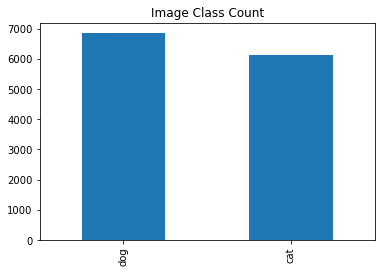

In [16]:
df.LabelName.value_counts().plot(kind='bar')
plt.title('Image Class Count')
plt.show()

In [17]:
df.describe()

Confidence          XMin          XMax          YMin          YMax  \
count     12966.0  12966.000000  12966.000000  12966.000000  12966.000000   
mean          1.0      0.099437      0.901750      0.088877      0.945022   
std           0.0      0.113023      0.111468      0.097345      0.081500   
min           1.0      0.000000      0.408125      0.000000      0.451389   
25%           1.0      0.000000      0.830625      0.000000      0.910000   
50%           1.0      0.061250      0.941682      0.059695      0.996875   
75%           1.0      0.167500      0.998889      0.144853      0.999062   
max           1.0      0.592500      1.000000      0.587088      1.000000   

         IsOccluded   IsTruncated     IsGroupOf   IsDepiction      IsInside  \
count  12966.000000  12966.000000  12966.000000  12966.000000  12966.000000   
mean       0.464754      0.738470      0.013651      0.045427      0.001157   
std        0.499239      0.440011      0.118019      0.209354      0.040229   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           XClick1X      XClick2X      XClick3X      XClick4X      XClick1Y  \
count  12966.000000  12966.000000  12966.000000  12966.000000  12966.000000   
mean       0.390356      0.424582      0.494143      0.506689      0.275434   
std        0.358313      0.441751      0.405033      0.462281      0.415511   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.221293      0.096875      0.285071      0.130000      0.024323   
50%        0.435625      0.415625      0.531919      0.623437      0.146319   
75%        0.609995      0.820000      0.787500      0.917529      0.561323   
max        0.999375      0.999375      1.000000      0.999375      0.999375   

           XClick2Y      XClick3Y      XClick4Y  
count  12966.000000  12966.000000  12966.000000  
mean       0.447448      0.641749      0.582910  
std        0.401580      0.448054      0.403454  
min       -1.000000     -1.000000     -1.000000  
25%        0.218333      0.405816      0.400000  
50%        0.480838      0.825000      0.646667  
75%        0.729069      0.998042      0.882500  
max        0.999375      1.000000      0.999375

## Sample of Images

By plotting random samples of the images along with the bounding boxes and XClick points, we see that every image has a bounding box but not every image has valid (positive) XClick information. From the descriptions on the CaDoD site, the bounding boxes were either derived from the extreme points clicked (aka XClick) by a human, or provided in some other way (prediction or manually drawn as a box). 

Further, it seems that the XClick items follow no system. For example, they are not in a predictable clockwise or counterclockwise ordering, they do not seem to start on a particular edge (like left side vs right side).

Since the bounding box information is more widely available and, where XClick is present, bounding box is derived from XClick, we can drop the XClick feature later on and just focus more on examining the bounding box attributes.

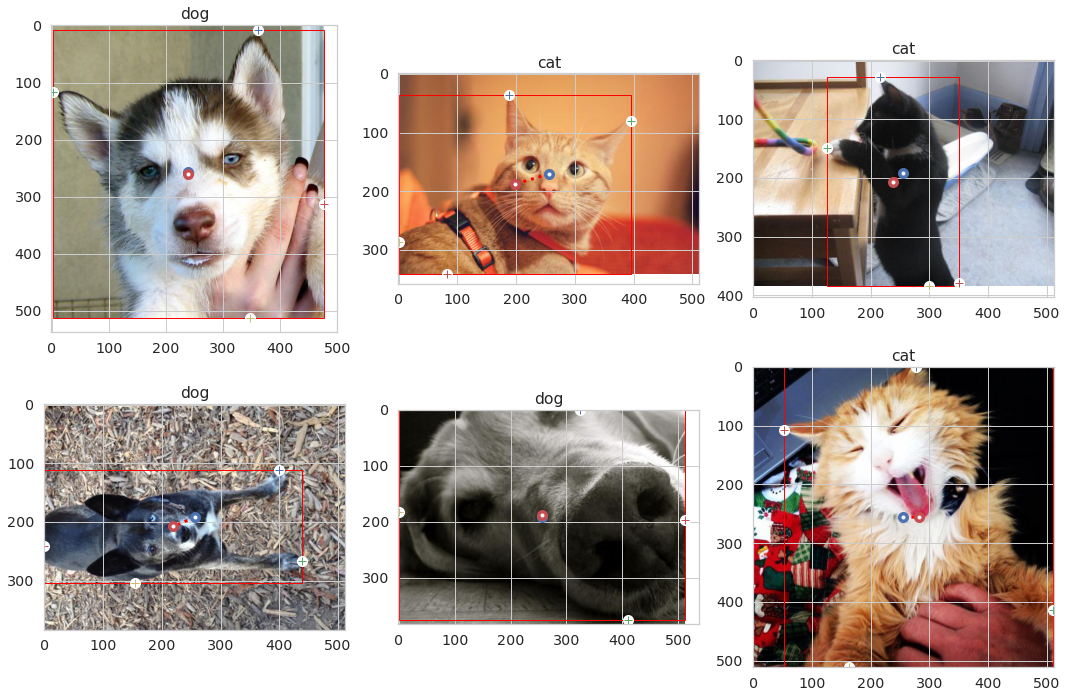

In [83]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    xclick_xcoords = df.iloc[j,13:17]*w
    xclick_ycoords = df.iloc[j,17:21]*h
    
    centerimg = [w/2, h/2]
    centerbox = [(coords[1]*w-coords[0]*w)/2 + coords[0]*w, (coords[3]*h-coords[2]*h)/2 + coords[2]*h]
    
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    
    # Plot the bounding box as a red border
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))
    
    ax[i].plot([centerimg[0], centerbox[0]],[centerimg[1], centerbox[1]],linestyle='dotted',linewidth=3,color='red')
    ax[i].plot(centerimg[0], centerimg[1],'bo', markersize=10)
    ax[i].plot(centerimg[0], centerimg[1],'w.')
    ax[i].plot(centerbox[0], centerbox[1],'ro', markersize=10)
    ax[i].plot(centerbox[0], centerbox[1],'w.')
    
    # If this image has valid positive XClick coords, plot those points
    if xclick_xcoords.any() < 0 or xclick_ycoords.any() < 0 :
        print("cannot plot, invalid (negative) xclick!")
    else :
        # plot each XClick point in scale on the image, 1 = blue, 2 = green, 3 = yellow, 4 = red
        ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'w.', markersize=20, label="1")
        ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'b+', markersize=8)
        ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'w.', markersize=20, label="2")
        ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'g+', markersize=8)
        ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'w.', markersize=20, label="3")
        ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'y+', markersize=8)
        ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'w.', markersize=20, label="4")
        ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'r+', markersize=8)
        
plt.tight_layout()
plt.show()

## Image shapes and sizes

Go through all images and record the shape of the image in pixels and the memory size

In [ ]:
img_shape = []
img_size = np.zeros((df.shape[0], 1))
img_format = []
for i,f in enumerate(tqdm(glob.glob1(path, '*.jpg'))):
    file = path+'/'+f
    img = Image.open(file)
    img_shape.append(f"{img.size[0]}x{img.size[1]}")
    imgratio = img.size[0]/img.size[1]
    if imgratio > 1 :
        img_format.append('landscape')
    elif imgratio < 1:
        img_format.append('portrait')
    else:
        img_format.append('square')
    img_size[i] += os.path.getsize(file)
    img.close() # cleanup!

  0%|          | 0/12966 [00:00<?, ?it/s]

Count all the different image shapes

In [103]:

img_shape_count = Counter(img_shape)
img_format_count = Counter(img_format)
img_format_count

Counter({'landscape': 5944, 'square': 735, 'portrait': 1247})

In [ ]:
# create a dataframe for image shapes
img_df = pd.DataFrame(set(img_shape_count.items()), columns=['img_shape','img_count'])

In [ ]:
img_df.shape
img_format_count

There are a ton of different image shapes. Let's narrow this down by getting a sum of any image shape that has a count less than 100 and put that in a category called `other`

In [139]:
img_df = img_df.append({'img_shape': 'other','img_count': img_df[img_df.img_count < 100].img_count.sum()}, 
                       ignore_index=True)

Drop all image shapes

In [140]:
img_df = img_df[img_df.img_count >= 100]

Check if the count sum matches the number of images

In [141]:
img_df.img_count.sum() == df.shape[0]

True

## Plot aspect ratio

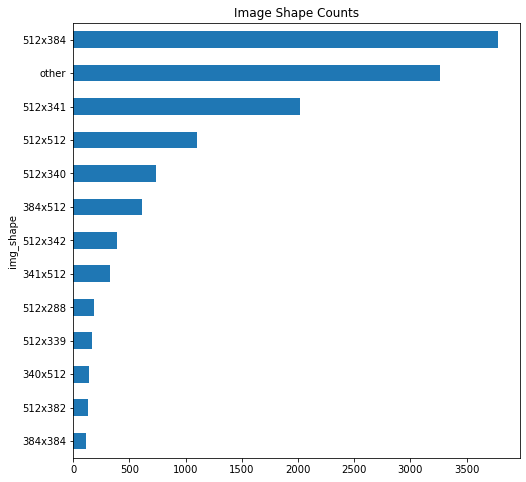

In [142]:
img_df.sort_values('img_count', inplace=True)
img_df.plot(x='img_shape', y='img_count', kind='barh', figsize=(8,8), legend=False)
plt.title('Image Shape Counts')
plt.show()

In [143]:
# convert to megabytes
img_size = img_size / 1000

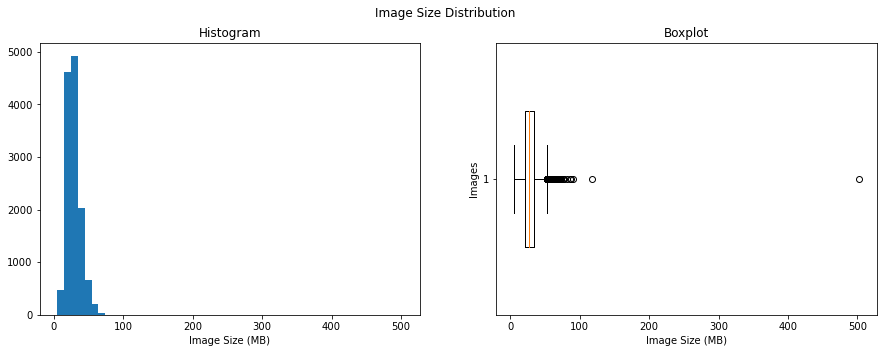

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Image Size Distribution')
ax[0].hist(img_size, bins=50)
ax[0].set_title('Histogram')
ax[0].set_xlabel('Image Size (MB)')
ax[1].boxplot(img_size, vert=False, widths=0.5)
ax[1].set_title('Boxplot')
ax[1].set_xlabel('Image Size (MB)')
ax[1].set_ylabel('Images')
plt.show()

# Preprocess

## Rescale the images

This rescaling will resize (and deform) all images to the same dimensions, 128 wide by 128 high.  The bounding box information in the CSV file are based on percentages and not pixel locations, so bounding box info is already normalized.  The rescaling of images to 128x128 in effect normalizes the image data so that we can better compare bounding boxes and images on the same dimensions without having to do further transformations.

In [145]:
!mkdir -p images/resized

In [146]:
%%time
# resize image and save, convert to numpy

img_arr = np.zeros((df.shape[0],128*128*3)) # initialize np.array

for i, f in enumerate(tqdm(df.ImageID)):
    img = Image.open(path+f+'.jpg')
    img_resized = img.resize((128,128))
    img_resized.save("images/resized/"+f+'.jpg', "JPEG", optimize=True)
    img_arr[i] = np.asarray(img_resized, dtype=np.uint8).flatten()
    img.close() # cleanup!

  0%|          | 0/12966 [00:00<?, ?it/s]

CPU times: user 2min 24s, sys: 16.4 s, total: 2min 41s
Wall time: 11min 7s


Plot the resized and filtered images

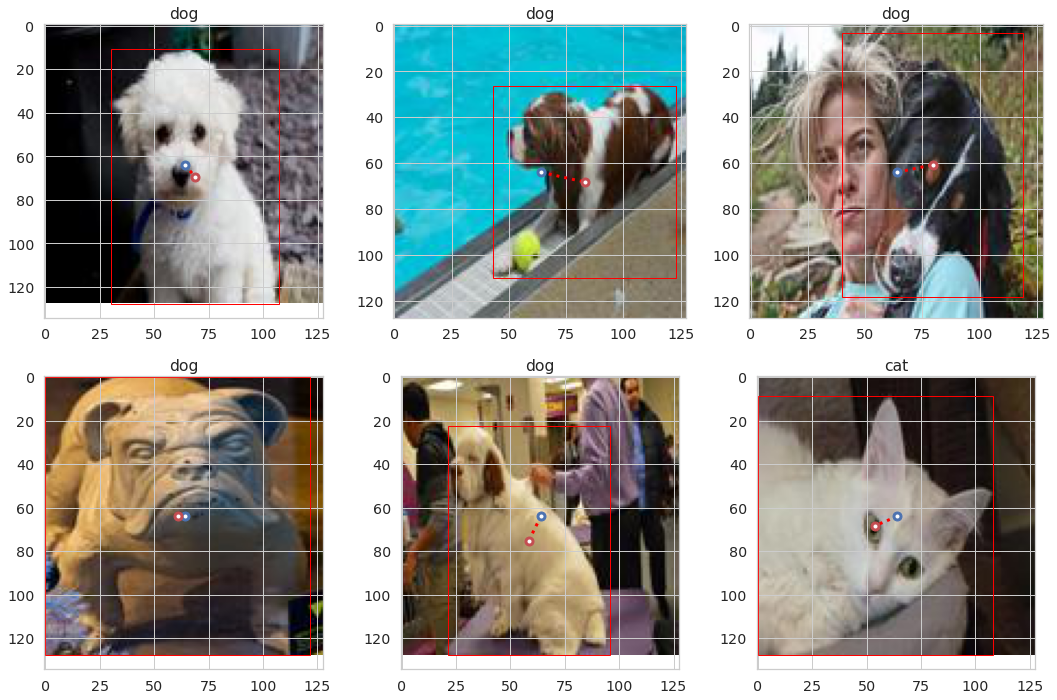

In [78]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    #imgpath = path+'resized/'+df.ImageID.values[j]+'.jpg' #this was looking in data/cadod/resized which didn't exist
    imgpath = 'images/resized/'+df.ImageID.values[j]+'.jpg'
    img = mpimg.imread(imgpath)
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    centerimg = [w/2, h/2]
    centerbox = [(coords[1]*w-coords[0]*w)/2 + coords[0]*w, (coords[3]*h-coords[2]*h)/2 + coords[2]*h]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j,2])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))
    # Plot the center of the image (will always be at (64,64) in green and white) and the center of the bounding box in red and white.
    ax[i].plot([centerimg[0], centerbox[0]],[centerimg[1], centerbox[1]],linestyle='dotted',linewidth=3,color='red')
    ax[i].plot(centerimg[0], centerimg[1],'bo', markersize=10)
    ax[i].plot(centerimg[0], centerimg[1],'w.')
    ax[i].plot(centerbox[0], centerbox[1],'ro', markersize=10)
    ax[i].plot(centerbox[0], centerbox[1],'w.')

plt.tight_layout()
plt.show()

In [148]:
# encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

## Checkpoint and Save data

In [149]:
mkdir -p data

In [150]:
np.save('data/img.npy', img_arr.astype(np.uint8), allow_pickle=True)
np.save('data/y_label.npy', df.Label.values, allow_pickle=True)
np.save('data/y_bbox.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32), allow_pickle=True)

# Baseline in SKLearn

## Load data

In [57]:
X = np.load('data/img.npy', allow_pickle=True, fix_imports=True)
y_label = np.load('data/y_label.npy', allow_pickle=True, fix_imports=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True, fix_imports=True)

In [58]:
idx_to_label = {1:'dog', 0:'cat'} # encoder

Double check that it loaded correctly

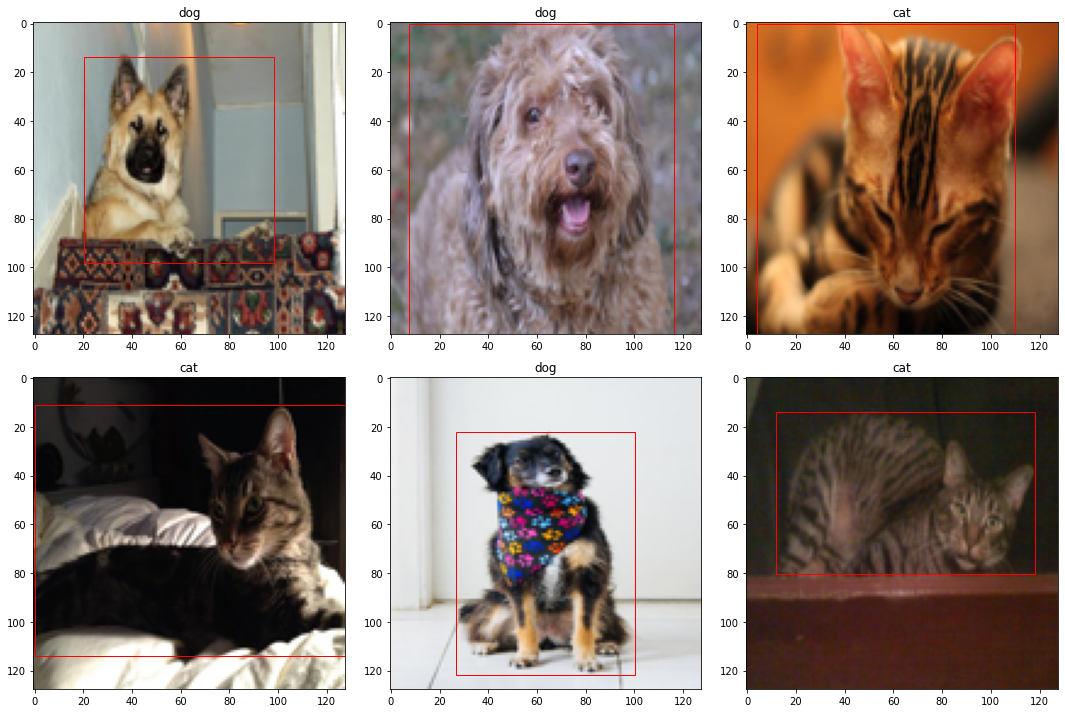

In [59]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X.shape[0], size=6, replace=False)):
    coords = y_bbox[j] * 128
    ax[i].imshow(X[j].reshape(128,128,3))
    ax[i].set_title(idx_to_label[y_label[j]])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

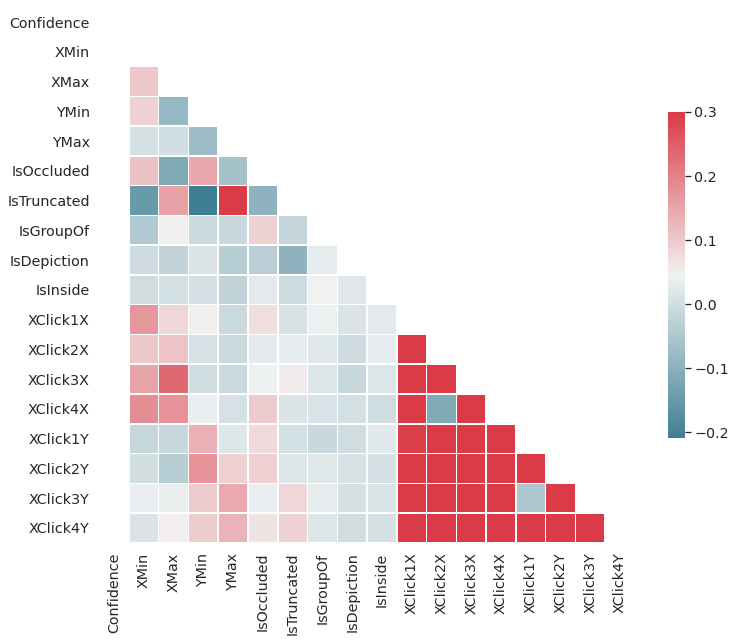

In [60]:
# data correlation LLM
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)

class_labels = ["cat", "dog"]

# compute the correlation matrix
corr = df.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [61]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Pipeline creation: LLM working
classification_pipeline = Pipeline(    #A pipeline for cat/dog classification predictions.
    [('scaler', StandardScaler()),
    ('classifier', LogisticRegression())])

#localization_pipeline = Pipeline([()])  #A pipeline for numeric bounding box predictions.

#full_pipeline = FeatureUnion([('class', classification_pipeline),('local', localization_pipeline)]) 

# Create a transformer to label the images as portrait, landscape, or square?
# Look at img_shape in img_df - it is WxH which we can split on x to get numeric width and numeric height.
# we can store w and h, and also determine ratio: w/h > 1 = landscape, w/h < 1 = portrait, w/h = 1 = square


## Table of results

We will track results of experiments in order to compare them for performance.

In [62]:
results = pd.DataFrame(columns=["Accuracy"])

## Classification

### Split data

Create training and testing sets

In [63]:
X_train, X_test, y_train, y_test_label = train_test_split(X, y_label, train_size=0.1, random_state=27)
# TODO: use 1 set for img, one set for box:
# X_train_img, X_test_img, y_train_img, y_test_label_img = train_test_split(X, y_label, train_size=0.1, random_state=27)
# X_train_box, X_test_box, y_train_box, y_test_label_box = train_test_split(X, y_label, train_size=0.1, random_state=27)
# TODO: later, adjust train size to 0.8 and reserve test of 0.2.

## Feature Engineering

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

#--------------------------------------------------
# Feature engineering
#--------------------------------------------------
# Derive the area features
class ImDimFeatures(BaseEstimator, TransformerMixin):
    """derive the image dimension features from the length and width features
       RETURNS
           a dataframe with all input columns + new columns describing image file
    """
    def __init__(self, ):
        pass
        
    def fit(self, X, y=None):
        # stateless transformer that does not depend on the data
        # it is a simple formula that is provided upfront: area = length x height
        return self
    
    def transform(self, X):
        # always copy the input frame - we don't want to impact the original frame in place
        # note here that transformed images are all 128x128 (normalized) so ignore img ratio
        self.col_names = list(X.columns) + ["bbox_w_percent",
                                            "bbox_h_percent",
                                            "bbox_area",
                                            "img_centerpt",
                                            "bbox_centerpt",
                                            "imgbboff_cx_pct", 
                                            "imgbboff_cy_pct",
                                            "num_touch_edges",
                                            "bb_touch_top",
                                            "bb_touch_left",
                                            "bb_touch_right",
                                            "bb_touch_bottom"]
        X = X.copy()
        
        # we can ignore XClick items as those are extreme points of the object and just contribute to XMin/Xmax YMin/Ymax which is the actual box.
        # XMin/Max and YMin/Max are NORMALIZED (out of 1.0) and so are percentages of the full image size.
        
        # XMax - XMin is the % width of the bounding box.
        X["bbox_w_percent"] = X["XMax"]-X["XMin"]
        
        # YMax - YMin is the % height of the bounding box.
        X["bbox_h_percent"] = X["YMax"]-X["YMin"]
        
        X["bbox_area"]=X["bbox_w_percent"]*X["bbox_h_percent"]
        
        # XMin + 1/2(XMax - XMin) would be the center of the bounding box in reference to the main image (offset)
        X["imgbboff_cx_pct"] = X["XMin"] + (X["bbox_w_percent"]/2)
        
        # Ymin + 1/2(YMax - YMin) would be the center of the bounding box in reference to the main image (offset)
        X["imgbboff_cy_pct"] = X["YMin"] + (X["bbox_h_percent"]/2)
        
        X["bb_touch_left"] = 1*(X["XMin"]==0)
        X["bb_touch_right"] = 1*(X["XMax"]==1)
        X["bb_touch_top"] = 1*(X["YMin"]==0)
        X["bb_touch_bottom"] = 1*(X["YMax"]==1)
        
        X["num_touch_edges"] = X["bb_touch_left"]+X["bb_touch_right"]+X["bb_touch_top"]+X["bb_touch_bottom"]
        
        # TODO: find centerpoints, drop XClick columns.
        X.drop(["XClick1X"], axis = 1, inplace=True),
        X.drop(["XClick1Y"], axis = 1, inplace=True)
        X.drop(["XClick2X"], axis = 1, inplace=True)
        X.drop(["XClick2Y"], axis = 1, inplace=True)
        X.drop(["XClick3X"], axis = 1, inplace=True)
        X.drop(["XClick3Y"], axis = 1, inplace=True)
        X.drop(["XClick4X"], axis = 1, inplace=True)
        X.drop(["XClick4Y"], axis = 1, inplace=True)
        return X
    
    def get_feature_names(self):
        return self.col_names

In [65]:
#--------------------------------
# Test the are transformer  step on the csv data
#--------------------------------
display(df.head())

imdimfeatures = ImDimFeatures().fit(df)
display(imdimfeatures.transform(df).head())

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick       dog           1  0.165000  0.903750   
1  0000cb13febe0138  xclick       dog           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick       dog           1  0.094167  0.611667   
3  0006303f02219b07  xclick       dog           1  0.000000  0.999219   
4  00064d23bf997652  xclick       dog           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick       dog           1  0.165000  0.903750   
1  0000cb13febe0138  xclick       dog           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick       dog           1  0.094167  0.611667   
3  0006303f02219b07  xclick       dog           1  0.000000  0.999219   
4  00064d23bf997652  xclick       dog           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  bbox_w_percent  \
0  0.268333  0.998333           1            1  ...        0.738750   
1  0.000000  0.999062           1            1  ...        0.651875   
2  0.055626  0.998736           1            1  ...        0.517500   
3  0.000000  0.998824           1            1  ...        0.999219   
4  0.000000  0.694286           0            0  ...        0.665245   

   bbox_h_percent  bbox_area  imgbboff_cx_pct  imgbboff_cy_pct  bb_touch_left  \
0        0.730000   0.539288         0.534375         0.633333              0   
1        0.999062   0.651264         0.325937         0.499531              1   
2        0.943110   0.488059         0.352917         0.527181              0   
3        0.998824   0.998044         0.499609         0.499412              1   
4        0.694286   0.461870         0.573561         0.347143              0   

   bb_touch_right  bb_touch_top  bb_touch_bottom  num_touch_edges  
0               0             0                0                0  
1               0             1                0                2  
2               0             0                0                0  
3               0             1                0                2  
4               0             1                0                1  

[5 rows x 23 columns]

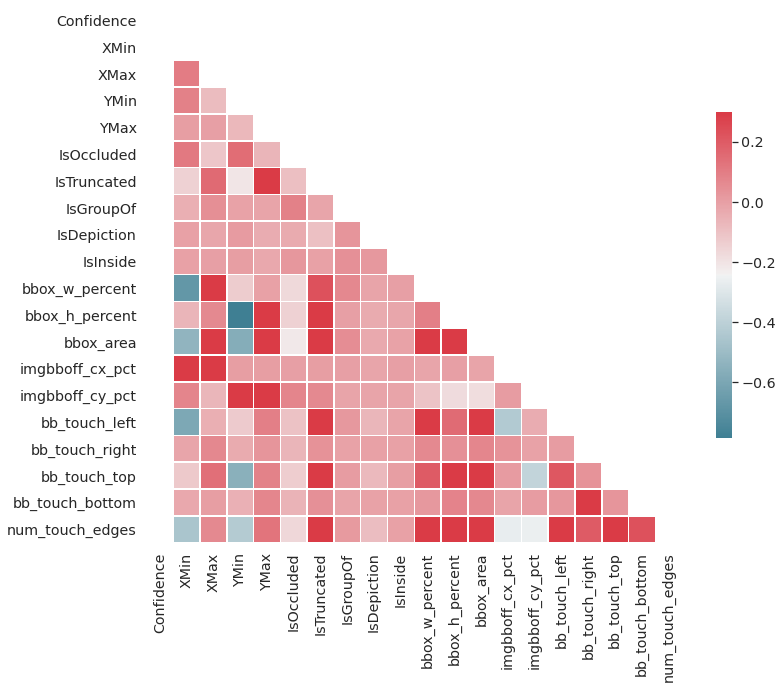

In [66]:
# data correlation on image dimension features LLM
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)

class_labels = ["cat", "dog"]

# compute the correlation matrix
corr = imdimfeatures.transform(df).corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

### Train

We're choosing `SGDClassifier` because the data is large and I want to be able to perform stochastic gradient descent and also its ability to early stop. With this many parameters, a model can easily overfit so it's important to try and find the point of where it begins to overfit and stop for optimal results.

In [ ]:
%%time
model = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10, 
                      early_stopping=True, validation_fraction=0.1, n_iter_no_change=3)
# 0.2 validation TODO

# Should we do cross fold validation here?
model.fit(X_train, y_train)

In [ ]:
model.n_iter_

4

Did it stop too early? Let's retrain with a few more iterations to see. Note that `SGDClassifier` has a parameter called `validation_fraction` which splits a validation set from the training data to determine when it stops.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

In [ ]:
model2 = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10)

epochs = 30

train_acc = np.zeros(epochs)
valid_acc = np.zeros(epochs)
for i in tqdm(range(epochs)):
    model2.partial_fit(X_train, y_train, np.unique(y_train))
    
    #log
    train_acc[i] += np.round(accuracy_score(y_train, model2.predict(X_train)),3)
    valid_acc[i] += np.round(accuracy_score(y_valid, model2.predict(X_valid)),3)

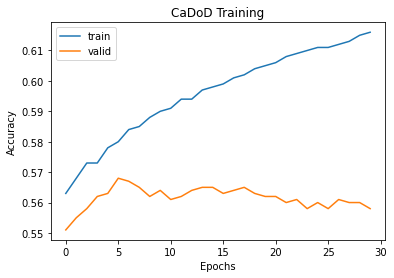

In [ ]:
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.title('CaDoD Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
del model2

### Evaluation

In [ ]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Acc", 
                               "Valid Acc",
                               "Test  Acc",
                               "Train MSE", 
                               "Valid MSE",
                               "Test  MSE",
                              ])

### Confusion matrices

A confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm.


In [ ]:
exp_name = f"Baseline: Linear Model"
expLog.loc[0,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test_label, model.predict(X_test))],3))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """


In [ ]:
expLog

exp_name Train Acc Valid Acc Test  Acc Train MSE Valid MSE  \
0  Baseline: SGDClassifier     0.584     0.574     0.554       NaN       NaN   

  Test  MSE  
0       NaN

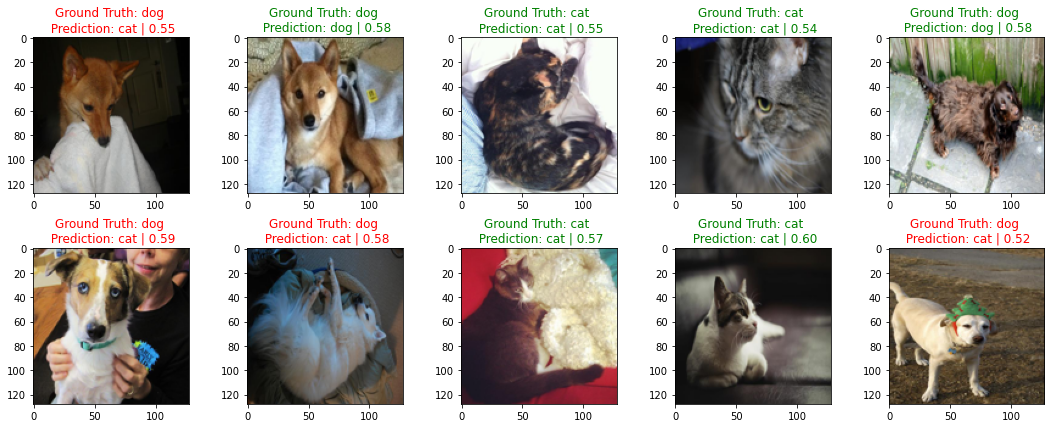

In [ ]:
y_pred_label = model.predict(X_test)
y_pred_label_proba = model.predict_proba(X_test)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False,figsize=(15,6))
ax = ax.flatten()

for i in range(10):
    img = X_test[i].reshape(128,128,3)
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[i]],
                                                                   idx_to_label[y_pred_label[i]],
                                                                   y_pred_label_proba[i][y_pred_label[i]]),
                   color=("green" if y_pred_label[i]==y_test_label[i] else "red"))

plt.tight_layout()
plt.show()

## Regression

### Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bbox, test_size=0.01, random_state=27)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

### Train

In [ ]:
%%time

from sklearn.linear_model import LinearRegression
# TODO closed loop solution, could use Lasso Ridge
model = ..... #fill in 
model.fit(X_train, y_train)

# might take a few minutes to train
#CPU times: user 1h 26min 40s, sys: 5min 53s, total: 1h 32min 34s
#Wall time: 17min 24s

CPU times: user 1h 26min 40s, sys: 5min 53s, total: 1h 32min 34s
Wall time: 17min 24s


LinearRegression(n_jobs=-1)

### Evaluation

In [ ]:
expLog.iloc[0,4:] = list(np.round([mean_squared_error(y_train, model.predict(X_train)), 
          mean_squared_error(y_valid, model.predict(X_valid)), 
          mean_squared_error(y_test, model.predict(X_test))],3))

expLog

exp_name Train Acc Valid Acc Test  Acc Train MSE Valid MSE  \
0  Baseline: Linear Model     0.584     0.574     0.554         0     0.036   

  Test  MSE  
0     0.035

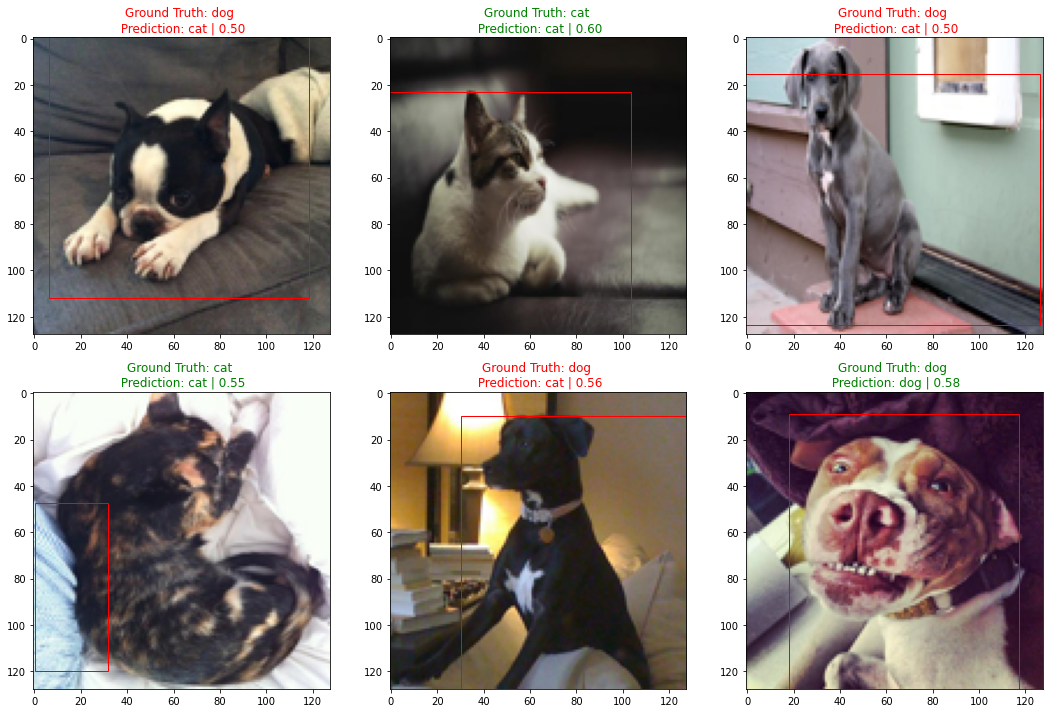

In [ ]:
y_pred_bbox = model.predict(X_test)

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_test.shape[0], size=6, replace=False)):
    img = X_test[j].reshape(128,128,3)
    coords = y_pred_bbox[j] * 128
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[j]],
                                                                   idx_to_label[y_pred_label[j]],
                                                                   y_pred_label_proba[j][y_pred_label[j]]),
                   color=("green" if y_pred_label[j]==y_test_label[j] else "red"))
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

### Cross-Validation

In [160]:
#From Lab Unit-07-Linear_classifiers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

acc = None
cm = None
estimator = [LogisticRegression(), RandomForestClassifier()]

for e in estimator:
    for train_idx, test_idx in cv_idx:

        # split
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # create logistic regression pipeline
        model = Pipeline([('scaler', MinMaxScaler()),
                          ('classifier', e)])

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # evaluate

        if acc is None:
            acc = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred).astype(np.float32)
        else:
            acc += accuracy_score(y_test, y_pred)
            cm += confusion_matrix(y_test, y_pred)
        
# take the average value across all folds
acc /= cv.n_splits
cm /= cm.sum(axis=1)[:, np.newaxis]

NameError: name 'LogisticRegression' is not defined

In [ ]:
plt.figure(figsize=(10, 8))
g = sns.heatmap(cm, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("CV", fontsize=14);

## Gridsearch to optimize hyperparameter selection for classification

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__penalty':['l1','l2'], 
              'classifier__C': [1, 10, 100, 1000, 10000]
             }

gs = GridSearchCV(pipe_model, param_grid, cv=5, verbose=2)

classification_pipeline.named_steps['classifier']

gs.fit(X_train, y_train)

# best grid search parameters
gs.best_params_

# best estimator
s = gs.best_estimator_.named_steps['scaler']

# access logistic regression coefficients from best estimator
gs.best_estimator_.named_steps['classifier'].coef_

# Homegrown implementation

Implement a Homegrown Logistic Regression model. Extend the loss function from CXE to CXE + MSE, i.e., make it a complex multitask loss function the resulting model   predicts the class and bounding box coordinates at the same time.

# Results / Discussion

# Conclusion